<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-Goals" data-toc-modified-id="Chapter-Goals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter Goals</a></span></li><li><span><a href="#Chapter-Outline" data-toc-modified-id="Chapter-Outline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Chapter Outline</a></span></li><li><span><a href="#Getting-and-Storing-a-Dataset" data-toc-modified-id="Getting-and-Storing-a-Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Getting and Storing a Dataset</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Getting-Stock-Data" data-toc-modified-id="Getting-Stock-Data-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Getting Stock Data</a></span></li><li><span><a href="#Create-and-Save-Return-Data-as-Parquet-file" data-toc-modified-id="Create-and-Save-Return-Data-as-Parquet-file-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Create and Save Return Data as Parquet file</a></span></li></ul></li></ul></li><li><span><a href="#Defining-Stationarity" data-toc-modified-id="Defining-Stationarity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Defining Stationarity</a></span></li><li><span><a href="#How-Asset-Returns-Violate-Rules-of-Stationarity" data-toc-modified-id="How-Asset-Returns-Violate-Rules-of-Stationarity-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>How Asset Returns Violate Rules of Stationarity</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#The-annual-means-and-standard-deviations-vary-signficantly-across-years." data-toc-modified-id="The-annual-means-and-standard-deviations-vary-signficantly-across-years.-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>The annual means and standard deviations vary signficantly across years.</a></span></li></ul></li><li><span><a href="#Examining-Autocorrelation" data-toc-modified-id="Examining-Autocorrelation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Examining Autocorrelation</a></span></li><li><span><a href="#The-Error-of-Using-The-Wrong-Distributions-Summary-Metrics" data-toc-modified-id="The-Error-of-Using-The-Wrong-Distributions-Summary-Metrics-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>The Error of Using The Wrong Distributions Summary Metrics</a></span><ul class="toc-item"><li><span><a href="#The-Kolmogorov-Smirnov-2-sample-test" data-toc-modified-id="The-Kolmogorov-Smirnov-2-sample-test-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>The Kolmogorov-Smirnov 2 sample test</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Resources-and-Citations" data-toc-modified-id="Resources-and-Citations-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Resources and Citations</a></span></li></ul></div>

## Chapter Goals

1. Understand the basics of stationarity
2. Understand how asset returns violate the rules of stationarity
3. Demonstrate that concept that asset returns can be considered as being generated by different distributions
4. Motivating the use of a more robust prediction methodology    

## Chapter Outline

1. Getting and Storing a Dataset
2. Defining Stationarity
3. How Asset Returns Violate Rules of Stationarity
4. Conclusions

## Getting and Storing a Dataset

Start by importing the required modules and tools

In [2]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

# import standard libs
from pathlib import Path
import sys
import time
import os

# get project dir
pp = Path(Path.cwd()).parts[:-1]
pdir = Path(*pp)
data_dir = pdir/'data'
script_dir = pdir / 'scripts' 
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from numba import jit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns
savefig_kwds=dict(dpi=300, bbox_inches='tight')

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set globals
plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Bitstream Vera Sans'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7

blue, gold, green, red, purple, brown = sns.color_palette('colorblind', 6)
nanex_colors = ("#f92b20", "#fe701b", "#facd1f", "#d6fd1c", "#65fe1b",
                "#1bfe42", "#1cfdb4", "#1fb9fa", "#1e71fb", "#261cfd")
nanex_cmap = mpl.colors.ListedColormap(nanex_colors,name='nanex_cmap')
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,pymc3,matplotlib,seaborn,plotnine

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-01-04T09:28:48-07:00

CPython 3.7.1
IPython 6.5.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.19.11-041911-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

pandas 0.23.4
pandas_datareader 0.7.0
numpy 1.15.4
sklearn 0.20.2
statsmodels 0.9.0
scipy 1.1.0
pymc3 3.6
matplotlib 3.0.2
seaborn 0.9.0
plotnine 0.5.1


#### Getting Stock Data 

Morningstar, Yahoo and Google finance data are now deprecated. To get free adjusted close data, sign up with [Tiingo](https://www.tiingo.com/account/billing/pricing) to get an API key. We'll get the closing price for multiple ETFs.

In [88]:
from dotenv import load_dotenv
load_dotenv() # to use hidden api key

In [92]:
def get_price(sym, start, end):
    return (pdr.get_data_tiingo(sym, start, end, api_key=os.getenv('api_key'))['adjClose']
            .reset_index(0,drop=True))

chosen_syms = ['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM']

end = pd.to_datetime('2017-12-31')
start = end - 25 * 252 * pd.tseries.offsets.BDay()

df = (pd.DataFrame
      .from_dict({sym:get_price(sym, start, end)
                  for sym in chosen_syms}))
cprint(df)

# save price data
outfp = Path(data_dir/'tiingo_etf_prices_ending_2017-12-31.parq')
df.to_parquet(outfp)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                SPY      QQQ      TLT      GLD     EFA     EEM
date                                                          
2017-12-22 262.4906 156.0359 121.4606 120.9400 68.0017 45.5161
2017-12-26 262.1766 155.1931 121.8208 121.7700 67.9823 45.4769
2017-12-27 262.3042 155.2130 123.4075 122.2300 68.1083 45.5944
2017-12-28 262.8439 155.4014 123.3004 122.8500 68.1471 45.9076
2017-12-29 261.8528 154.4396 123.4951 123.6500 68.1956 46.1230
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6081 entries, 1993-11-08 to 2017-12-29
Data columns (total 6 columns):
SPY    6081 non-null float64
QQQ    4735 non-null float64
TLT    3886 non-null float64
GLD    3302 non-null float64
EFA    4118 non-null float64
EEM    3706 non-null float64
dtypes: float64(6)
memory us

#### Create and Save Return Data as Parquet file

Please note that although this dataset is small enough to save as csv or h5, if you intend on dealing with larger datasets aka "big data" on "distributed systems" I recommend developing the `parquet` habit now. This will save you time and storage costs down the road.

In [93]:
# compute returns

R = np.log(df/df.shift(1)).dropna()
cprint(R)

outfp = Path(data_dir/'tiingo_etf_returns_ending_2017-12-31.parq')
R.to_parquet(outfp)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY     QQQ     TLT    GLD     EFA     EEM
date                                                     
2017-12-22 -0.0003 -0.0011  0.0014 0.0052  0.0026  0.0084
2017-12-26 -0.0012 -0.0054  0.0030 0.0068 -0.0003 -0.0009
2017-12-27  0.0005  0.0001  0.0129 0.0038  0.0019  0.0026
2017-12-28  0.0021  0.0012 -0.0009 0.0051  0.0006  0.0068
2017-12-29 -0.0038 -0.0062  0.0016 0.0065  0.0007  0.0047
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3301 entries, 2004-11-19 to 2017-12-29
Data columns (total 6 columns):
SPY    3301 non-null float64
QQQ    3301 non-null float64
TLT    3301 non-null float64
GLD    3301 non-null float64
EFA    3301 non-null float64
EEM    3301 non-null float64
dtypes: float64(6)
memory usage: 180.5 KB
None
----------------

After saving the data we can load back into the environment like so...

In [4]:
infp = Path(data_dir/'tiingo_etf_returns_ending_2017-12-31.parq')
R = (pd.read_parquet(infp)
     .assign(year=lambda df: df.index.year)) # add year column for later conv.
cprint(R)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY     QQQ     TLT    GLD     EFA     EEM  year
date                                                           
2017-12-22 -0.0003 -0.0011  0.0014 0.0052  0.0026  0.0084  2017
2017-12-26 -0.0012 -0.0054  0.0030 0.0068 -0.0003 -0.0009  2017
2017-12-27  0.0005  0.0001  0.0129 0.0038  0.0019  0.0026  2017
2017-12-28  0.0021  0.0012 -0.0009 0.0051  0.0006  0.0068  2017
2017-12-29 -0.0038 -0.0062  0.0016 0.0065  0.0007  0.0047  2017
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3301 entries, 2004-11-19 to 2017-12-29
Data columns (total 7 columns):
SPY     3301 non-null float64
QQQ     3301 non-null float64
TLT     3301 non-null float64
GLD     3301 non-null float64
EFA     3301 non-null float64
EEM     3301 non-null float64
year    3301 no

Please be aware that the load function used above immediately converts the `parquet` file into a `pandas.DataFrame` object. For smaller datasets and modern laptop hardware that is not a problem (less than 1 `gb`). However once your dataset starts getting into the multi `gb` range one might experience delayed performance in which case I would recommend learning and using [Dask](http://dask.pydata.org/en/latest/).

## Defining Stationarity

The following image sums up this concept best. The simple intuition is that the series mean and variance should NOT change as a result of passing time. The covariance between returns in the time series should also NOT be a function of time.

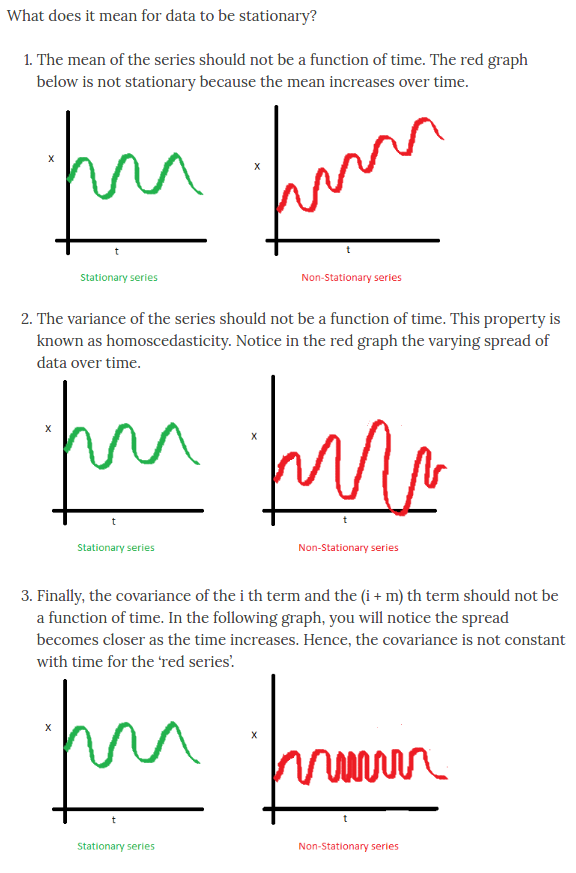

In [7]:
from IPython.display import Image

media = './visuals/01_Motivation/stationarity infographic screenshot-www.seanabu.com-2016-11-01-14-16-35.png'
Image(media)

## How Asset Returns Violate Rules of Stationarity

Now that you are familiarized with the concept of stationary time series, the remainder of this notebook will demonstrate/discuss some of the nuances and challenges one runs into in when trying to predict time series. 

Before we start just know that the behavior of securities' returns challenges these requirements of stationarity and our attempts to predict them in ways that are sometimes unknowable. This is a very humbling realization but is a necessary fact that requires a strategic response in the practice of return prediction.

#### The annual means and standard deviations vary signficantly across years.

One way we can examine whether the returns are stationary is looking at the mean and standard deviation of returns by year. If those two quantities are not supposed to be a function of time then they should be pretty similar across years, right?

Just by eyeballing the plots below you can see how varied the means and volatilities are. Sometimes the mean return is highly negative while volatility is spiked like in 2008-09 or it can be positive while volatlility is much lower as in 2017. 

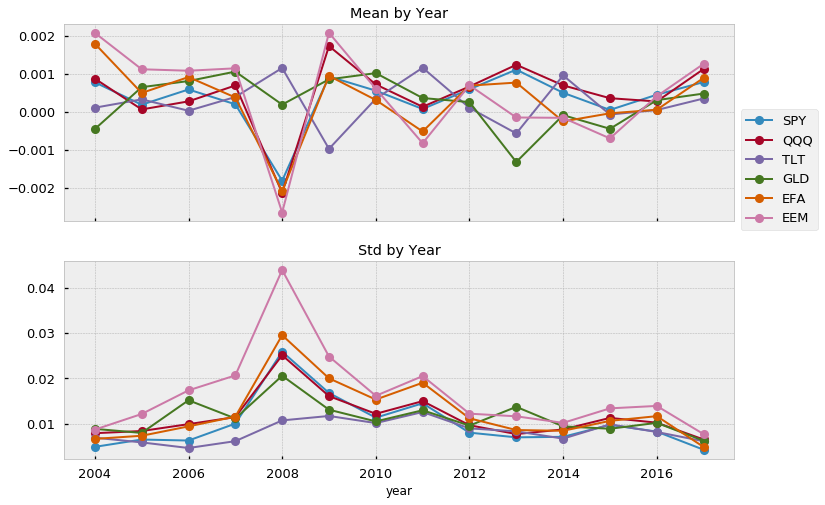

In [5]:
#for sym in R.columns[:-1]:

f,axes = plt.subplots(2, sharex=True, figsize=(12,8))
(R.groupby('year').agg(['mean']).plot(ax=axes[0],marker='o'));
(R.groupby('year').agg(['std']).plot(ax=axes[1],marker='o'));
axes[0].legend(R.columns[:-1], bbox_to_anchor=(1.0, .6))
axes[1].legend().set_visible(False)
axes[0].set_title('Mean by Year')
axes[1].set_title('Std by Year');

We can look at the KDE plots of the distributions by year and see that for for every symbol, each year the distribution is different in height and width when compared to other years.

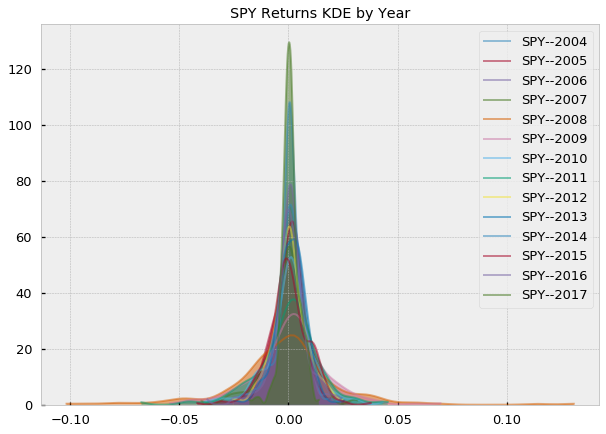

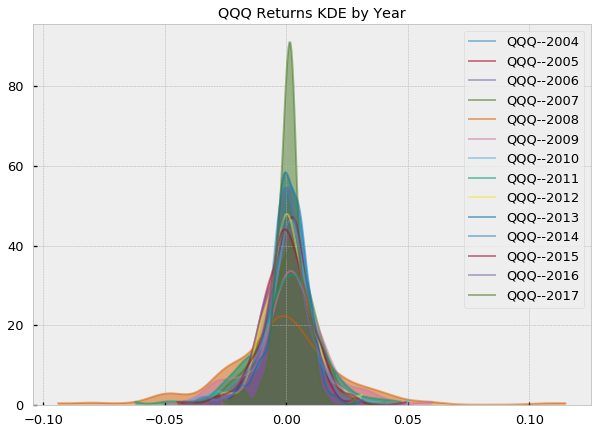

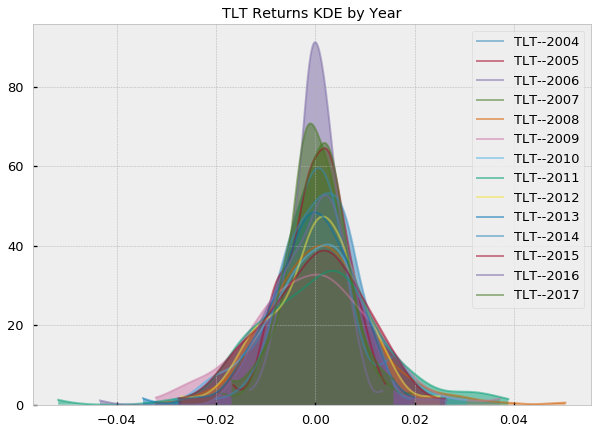

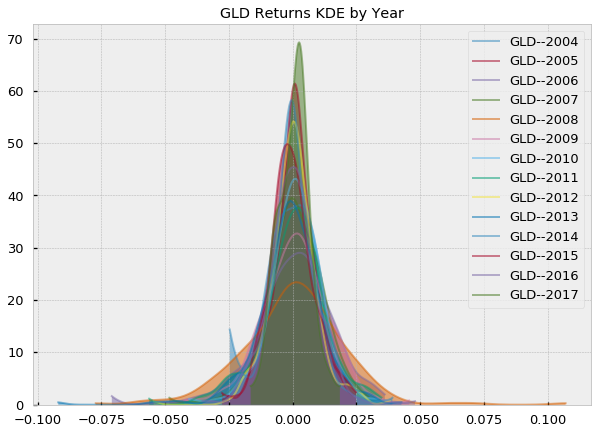

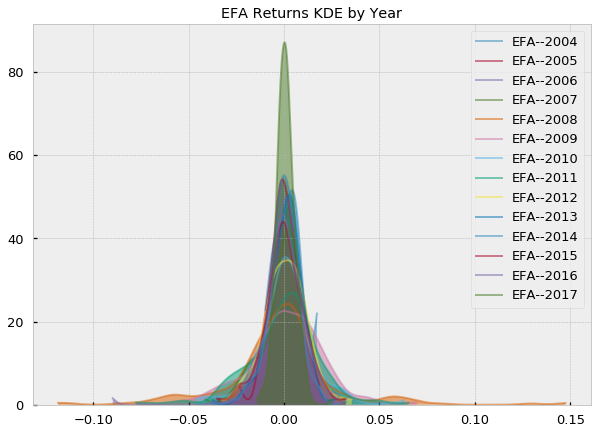

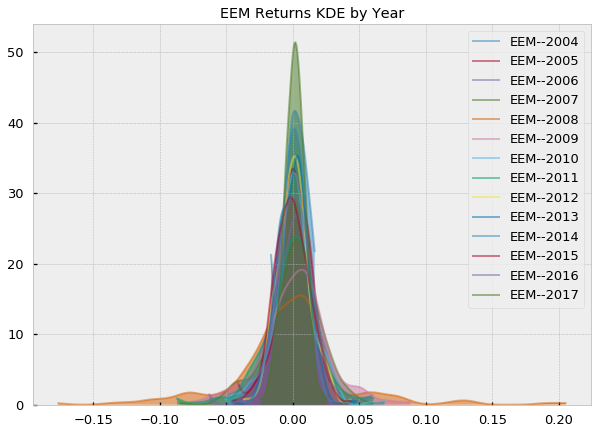

In [6]:
for sym in R.columns[:-1]:
    f, ax = plt.subplots()
    for year in R.year.unique():
        sns.kdeplot(R.query('year==@year')[sym], ax=ax,
                    shade=True, label=f'{sym}--{year}', cut=0, alpha=0.5)
    plt.title(f'{sym} Returns KDE by Year')

We can see the same result by looking at the cumulative distribution as well.

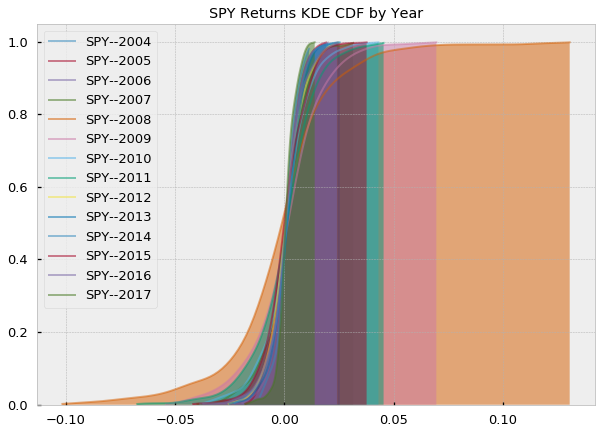

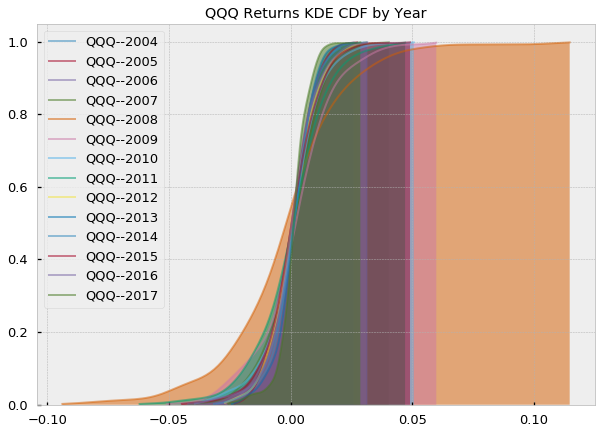

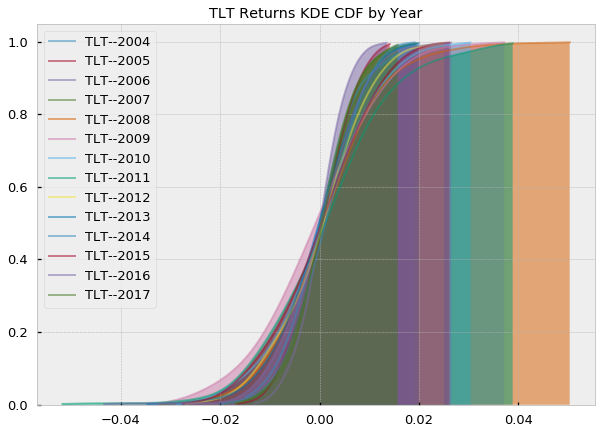

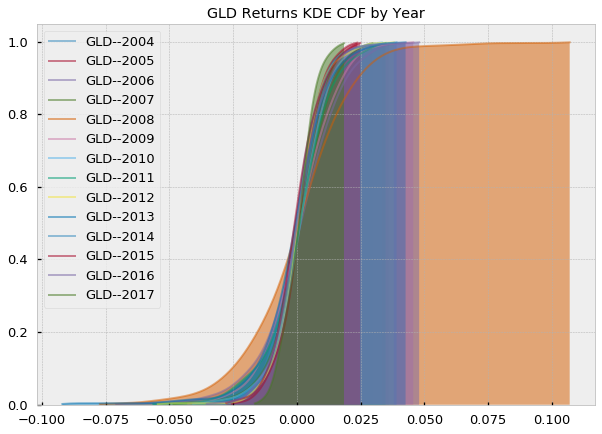

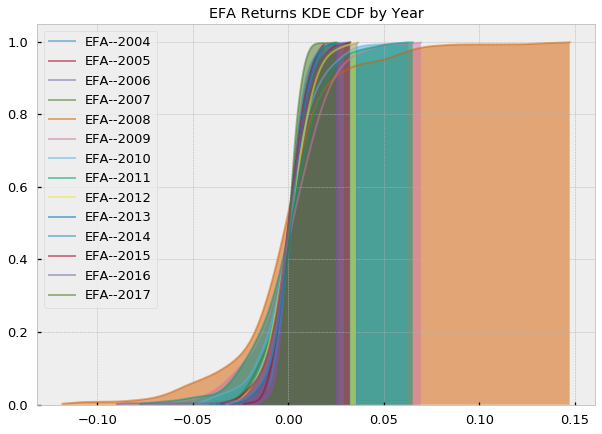

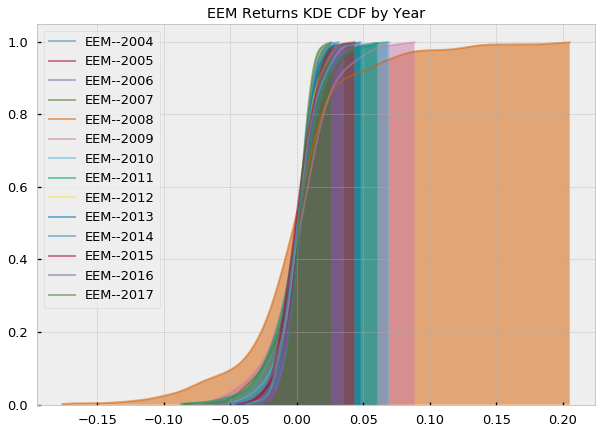

In [7]:
for sym in R.columns[:-1]:
    f, ax = plt.subplots()
    for year in R.year.unique():
        sns.kdeplot(R.query('year==@year')[sym], ax=ax,
                    shade=True, label=f'{sym}--{year}', cut=0, 
                    cumulative=True, alpha=0.5)
    plt.title(f'{sym} Returns KDE CDF by Year')

### Examining Autocorrelation

Finally we can look for evidence of correlated data points by plotting the return series and its autocorrelation and partial autocorrelation function. First we'll plot the entire period, and then the faceted plots by year.

In [12]:
def tsplot(y, lags=None, figsize=(12, 12), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        
        #y.plot(ax=ts_ax)
        y.plot(ax=ts_ax, marker='o', c='gray', ms=5.,
               markerfacecolor=blue, markeredgecolor='white', markeredgewidth=.25)        
        ts_ax.set_title(f'{y.name}')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax, marker='X', markerfacecolor=blue,
                  markeredgecolor='k', markeredgewidth=0.25)
        qq_ax.set_title('QQ Plot')        
        plt.tight_layout()
    return 

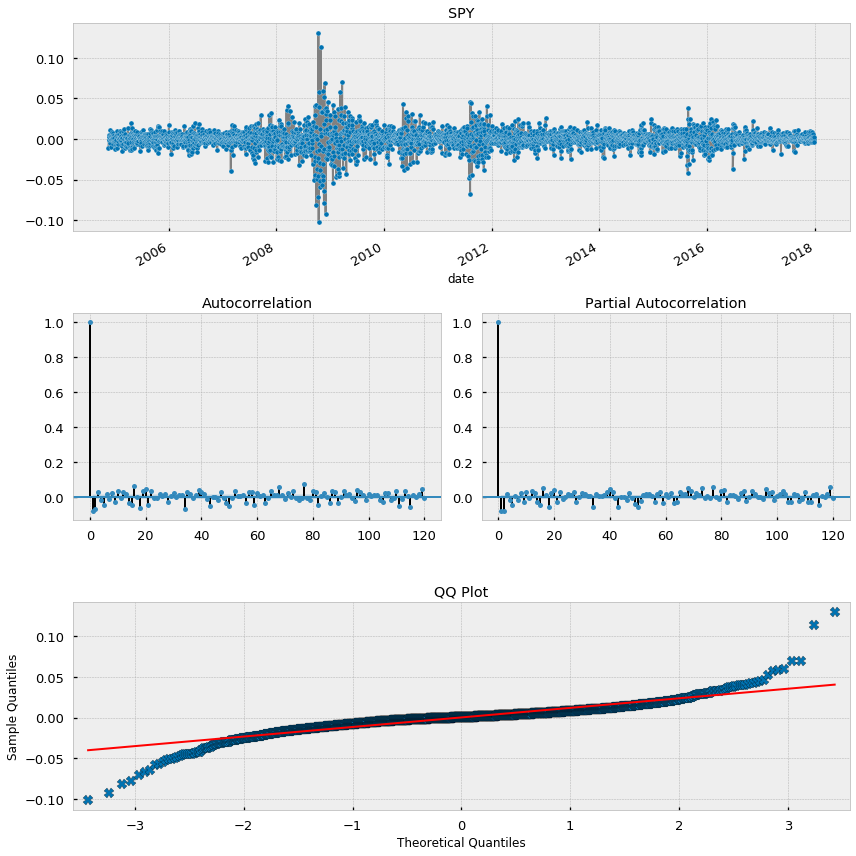

In [13]:
tsplot(R['SPY'], lags=120)

In [14]:
def facet_tsplot(df, sym, *args):
    """
    fn: to plot faceted timeseries plot using gridspec
    
    Params
    ------
    df : pd.DataFrame(), return data
    sym : str(), etf symbol
    _lags : numeric
    _years : array-like, list of years
    _dt : int(), number of columns
    _partial_len : int(), number of rows
    """

    fig = plt.figure(figsize=(25,60))
    outer_grid = gridspec.GridSpec(_partial_len, _dt)

    for i, year in zip(range(int(_partial_len*_dt)), _years):        
        
        y = df.query('year==@year')[sym]
        
        inner_grid = gridspec.GridSpecFromSubplotSpec(3, 2,
                                                      subplot_spec=outer_grid[i],
                                                      wspace=0.0, hspace=0.5)

        ts_ax = plt.Subplot(fig, inner_grid[0, :])
        acf_ax = plt.Subplot(fig, inner_grid[1, 0])
        pacf_ax = plt.Subplot(fig, inner_grid[1, -1])
        qq_ax = plt.Subplot(fig, inner_grid[2, :])
        
        y.plot(ax=ts_ax, marker='o', c='gray', ms=5.,
               markerfacecolor=blue, markeredgecolor='white', markeredgewidth=.25)         
        smt.graphics.plot_acf(y, lags=_lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=_lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax, marker='X', markerfacecolor=blue,
                  markeredgecolor='k', markeredgewidth=0.25)
    
        ts_ax.axhline(0, color='k', ls='--', lw=2.)
        ts_ax.tick_params(axis='x', size=9)
        ts_ax.set_title(f'{sym}-{year}', y=.8, fontweight='demi')

        pacf_ax.set_yticklabels([])

        fig.add_subplot(ts_ax)
        fig.add_subplot(acf_ax)
        fig.add_subplot(pacf_ax)
        fig.add_subplot(qq_ax)

        sns.despine()

    plt.show()
    return

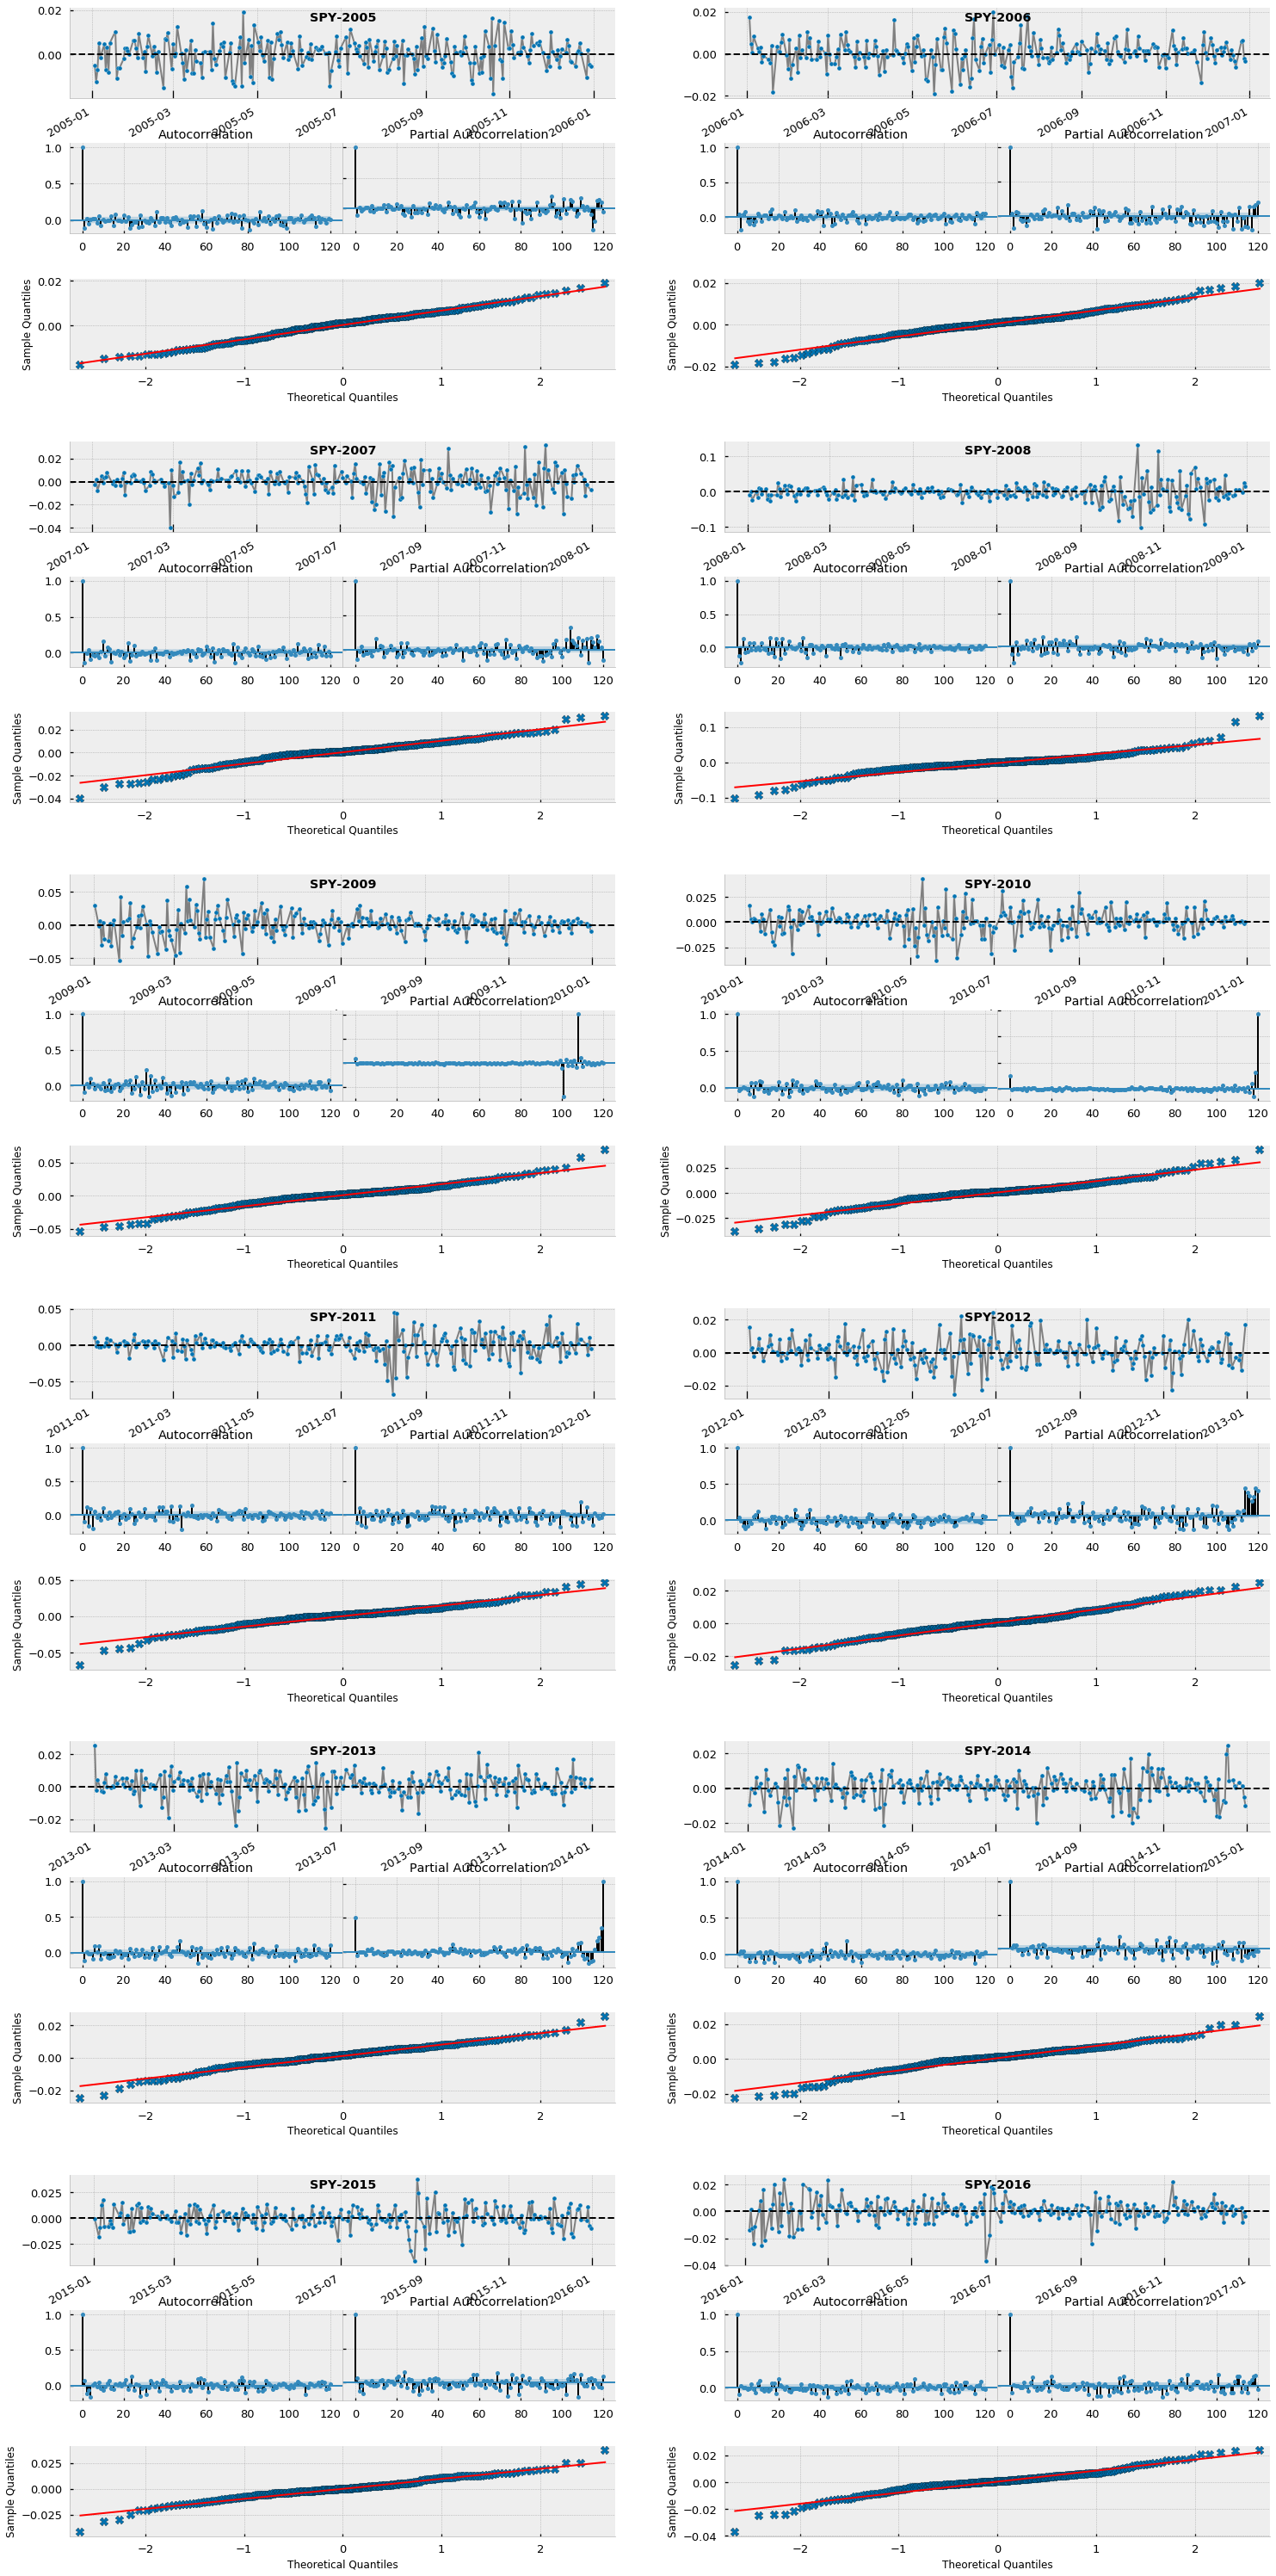

In [15]:
_years = np.arange(2005, R.year.max()) # 2005 is first full year
# array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

_dt = 2
_partial_len = int(len(_years)/_dt)
_lags = 120

SYM = 'SPY'
facet_tsplot(R, SYM, _lags, _years, _dt, _partial_len)    
#plt.savefig(f'./visuals/01_Motivation/spy return faceted tsplot acf and pacf.png', dpi=300, bbox_inches='tight') 

So we can see clearly that SPY returns are nonstationary in the mean, in the variance, and demonstrate periods of variable autocorrelation. 

### The Error of Using The Wrong Distributions Summary Metrics

So what happens when we try to use past returns approximated by a normal distribution's summary metrics (mean, variance) to predict future return distributions?

To explore this we'll use (`TimeSeriesSplit`) method from `sklearn`. This provides a walf-forward form of cross validation where previous data points, are used to predict the following period in sequence, thus preserving time dependent information. 

#### The Kolmogorov-Smirnov 2 sample test

We'll be using the `scipy stats.ks_2samp` test to compare the train and test distributions. This is a statistical test that assumes the 2 data samples came from the same distribution. If the p-value is really small then we have strong evidence that the 2 data samples came from different distributions. An example test is below.

In [79]:
np.random.seed(0)
test_rvs_norm = stats.norm.rvs(loc=0,scale=1,size=100000)
test_rvs_norm_2 = stats.norm.rvs(loc=0,scale=1,size=100000)
test_rvs_gamma = stats.gamma.rvs(a=1,loc=0,scale=1, size=100000)

print('norm vs gamma: ', stats.ks_2samp(test_rvs_norm, test_rvs_gamma))
print('norm vs norm: ', stats.ks_2samp(test_rvs_norm, test_rvs_norm_2))

norm vs gamma:  Ks_2sampResult(statistic=0.49933, pvalue=0.0)
norm vs norm:  Ks_2sampResult(statistic=0.0035999999999999366, pvalue=0.5353525616101535)


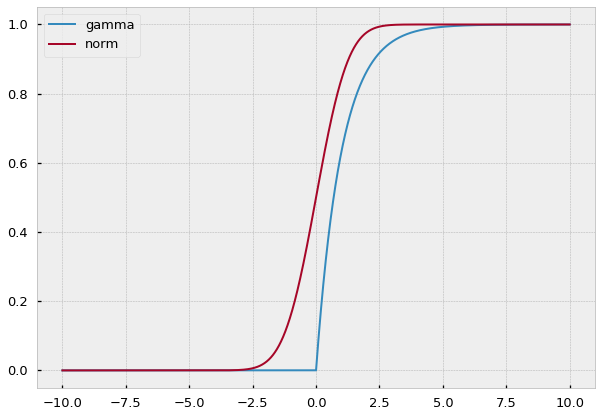

In [77]:
xt = np.linspace(-10,10,len(test_rvs_norm))
plt.plot(xt, stats.gamma.cdf(xt,a=1,loc=0,scale=1), label='gamma')
plt.plot(xt, stats.norm.cdf(xt,loc=0,scale=1), label='norm')
plt.legend()

CPU times: user 7.05 s, sys: 0 ns, total: 7.05 s
Wall time: 7.05 s


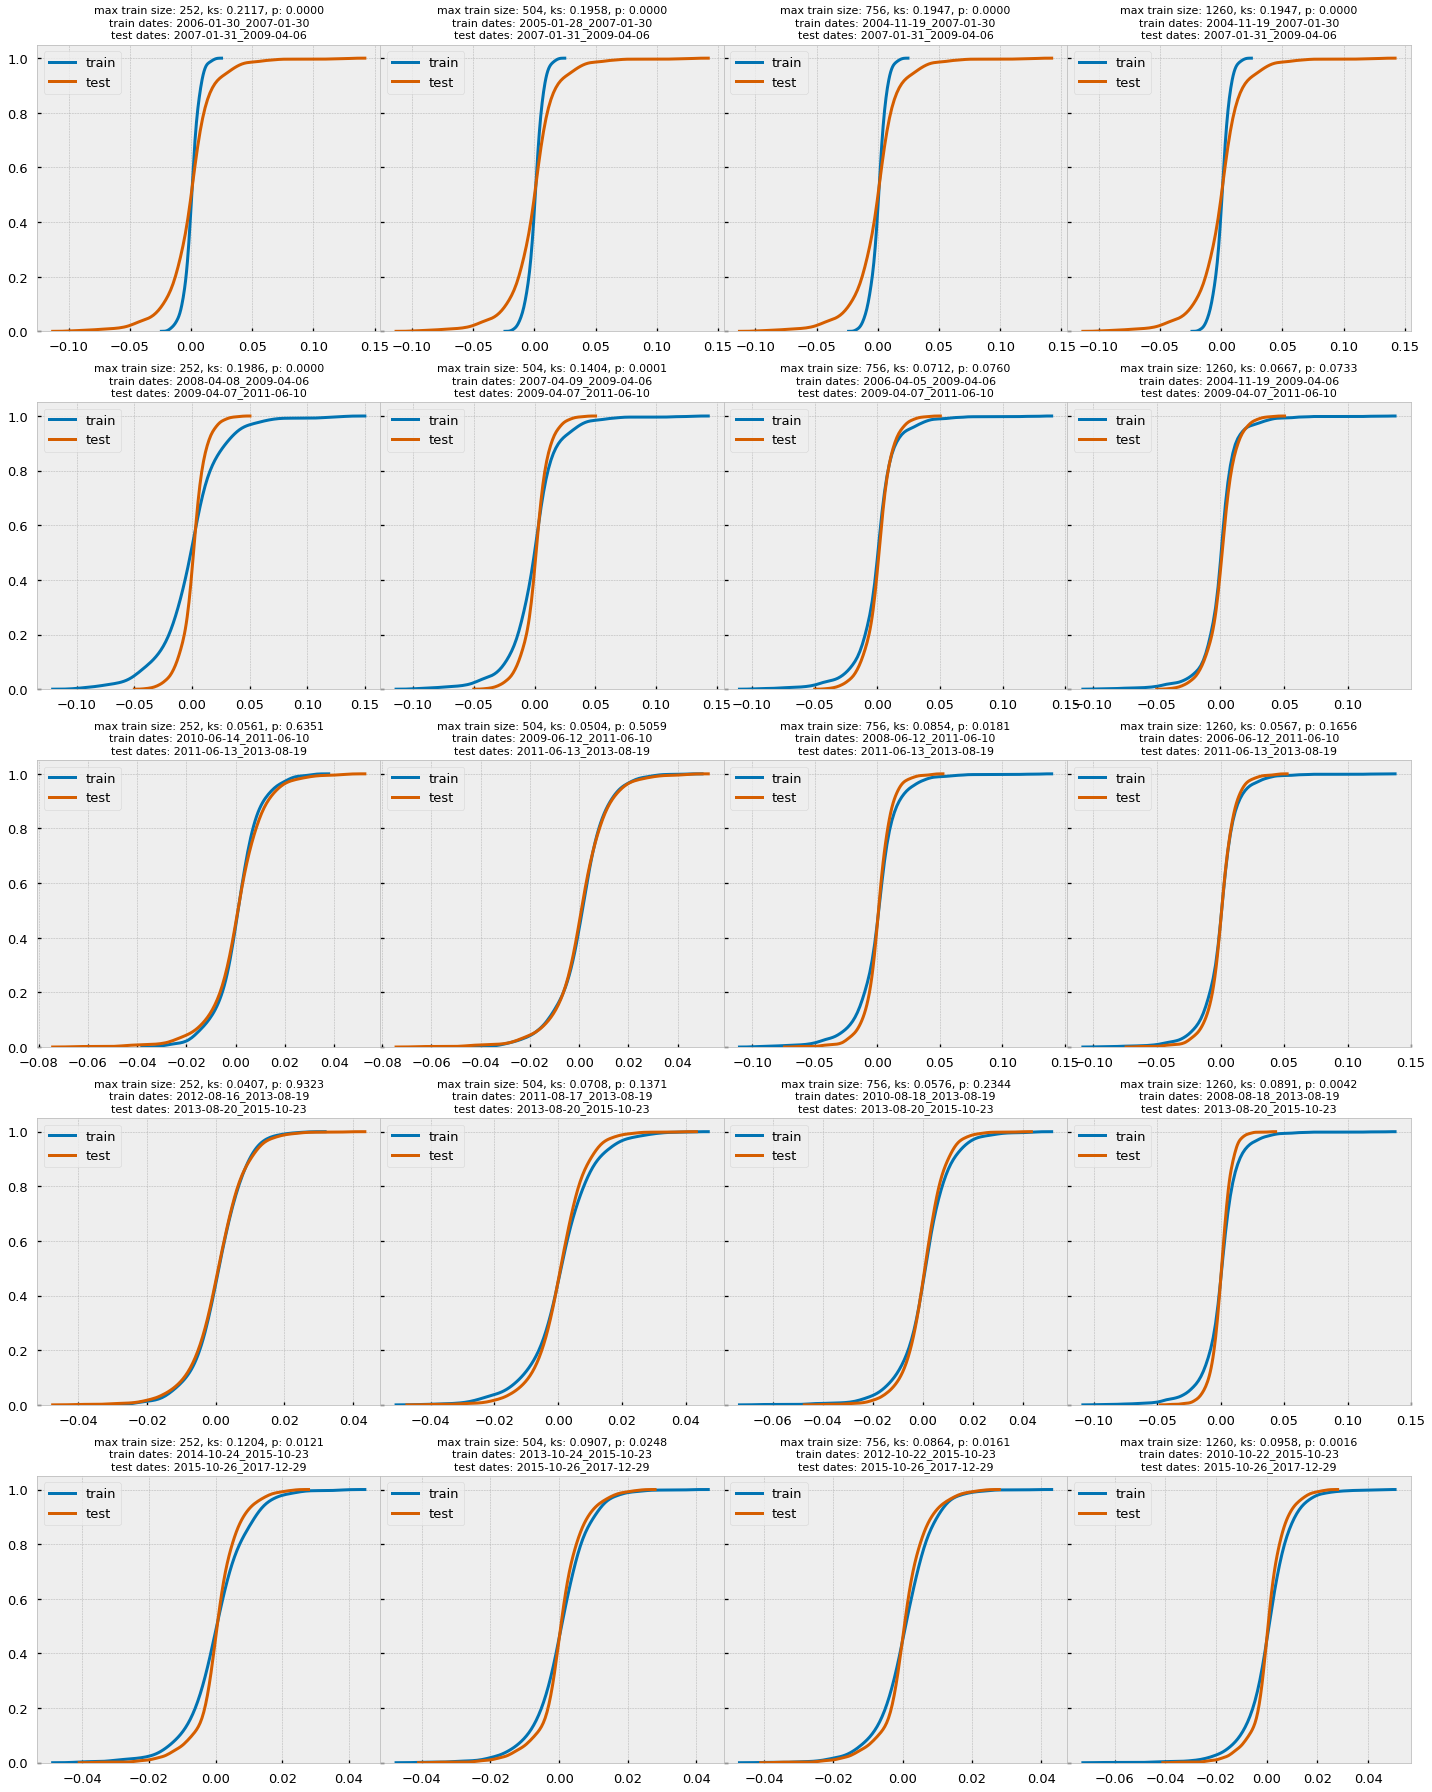

In [16]:
%%time

from sklearn.model_selection import TimeSeriesSplit

xx = R[SYM].copy() # pd series representing example data

_base = 252 # 1 trading year
_max_train_sizes = [_base*1, _base*2, _base*3, _base*5] # historical lookbacks
_n_split=5 # try with different values

gs = gridspec.GridSpec(_n_split, len(_max_train_sizes), wspace=0.0)

fig = plt.figure(figsize=(20,25))

rows = []
for j, max_size in enumerate(_max_train_sizes):
    tscv = TimeSeriesSplit(n_splits=_n_split, max_train_size=max_size)
    
    for i, (train, test) in enumerate(tscv.split(xx)):
        tmp_train = xx.iloc[train] # temporary train data
        tmp_test = xx.iloc[test] # temporary test data
        
        # get date ranges for datasets
        min_train_dt, max_train_dt = tmp_train.index.min(), tmp_train.index.max()
        min_test_dt, max_test_dt = tmp_test.index.min(), tmp_test.index.max()
        
        # compare train distro vs test distro 
        #   https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
        ks, p = stats.ks_2samp(tmp_train, tmp_test) # get ks statistic and pvalue
        
        df_row = (max_size, ks, p,
                  min_train_dt.date(), max_train_dt.date(),
                  min_test_dt.date(), max_test_dt.date())
        rows.append(df_row) # append data for df
        
        tmp_ax = plt.subplot(gs[i, j]) # get temp ax from gridspec object
        
        # remove yticks except for first column
        if i in [0,1,2,3,4] and j != 0: tmp_ax.set_yticklabels([])
        # plot cdfs
        sns.kdeplot(tmp_train, cumulative=True, lw=3, color=blue, ax=tmp_ax, label='train')
        sns.kdeplot(tmp_test, cumulative=True, lw=3, color=red, ax=tmp_ax, label='test')
        plt.title('max train size: {}, ks: {:.4f}, p: {:.4f}\ntrain dates: {}_{}\ntest dates: {}_{}'
                  .format(max_size, ks, p,
                          min_train_dt.date(), max_train_dt.date(),
                          min_test_dt.date(), max_test_dt.date()), 
                  fontsize=11.)
        plt.subplots_adjust(top=1.03) # adjust title spacing
        plt.tight_layout()
#plt.savefig(f'./visuals/01_Motivation/spy return cdf compare-time series split {_n_split} folds-kstest.png',
#            dpi=300, bbox_inches='tight') 

We can see how varied the CDF for train and test periods are throughout the different lookback periods, including times where they sync up exactly. To quantify our observations, we can create a dataframe containing the output of the ks test along with the information on the lookback periods and the data splits.

In [17]:
def color_if_diff_dist(val, alpha=0.05):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for values 
    less than alpha, black otherwise.
    """
    color = 'darkgreen' if val < alpha else 'k'
    return 'color: %s' % color

def highlight_diff_dist(val, alpha=0.05):
    """
    highlight the values less than alpha as yellow.
    """
    color = 'yellow' if val < alpha else ''
    return 'background-color: %s' % color

# create data table with ks test results and ts information
cols = ['max_size', 'ks', 'p', 
        'min_train_dt', 'max_train_dt',
        'min_test_dt', 'max_test_dt']
tss_ks_df = pd.DataFrame(rows, columns=cols)

(tss_ks_df.style
 .applymap(color_if_diff_dist, subset=['p'])
 .applymap(highlight_diff_dist, subset=['p']))

We can now examine the percentage of train/test pairs that reject the null hypothesis at alpha equal to 0.05 and 0.01.

In [18]:
get_pct_reject = lambda df, col, alpha: df.query(f'{col} < {alpha}').shape[0] / df.shape[0]

a1 = 0.05
a2 = 0.01

# percentage of rejected null hypothesis that the samples came from the same distribution
#  at alphas 0.05 and 0.01 respectively
get_pct_reject(tss_ks_df, 'p', a1), get_pct_reject(tss_ks_df, 'p', a2) 

(0.6, 0.4)

Unsurprisingly the results are terrible. 60% of the train/test pairs reject the null hypothesis that the training and testing data came from the same distribution. This proves that if we were to apply the mean, variance parameters of the training data to predict the test data return distribution we're going to be wrong a lot of the time.

For fun we can look at the periods where the kstest accepts the null hypothesis and see if any patterns jump out.

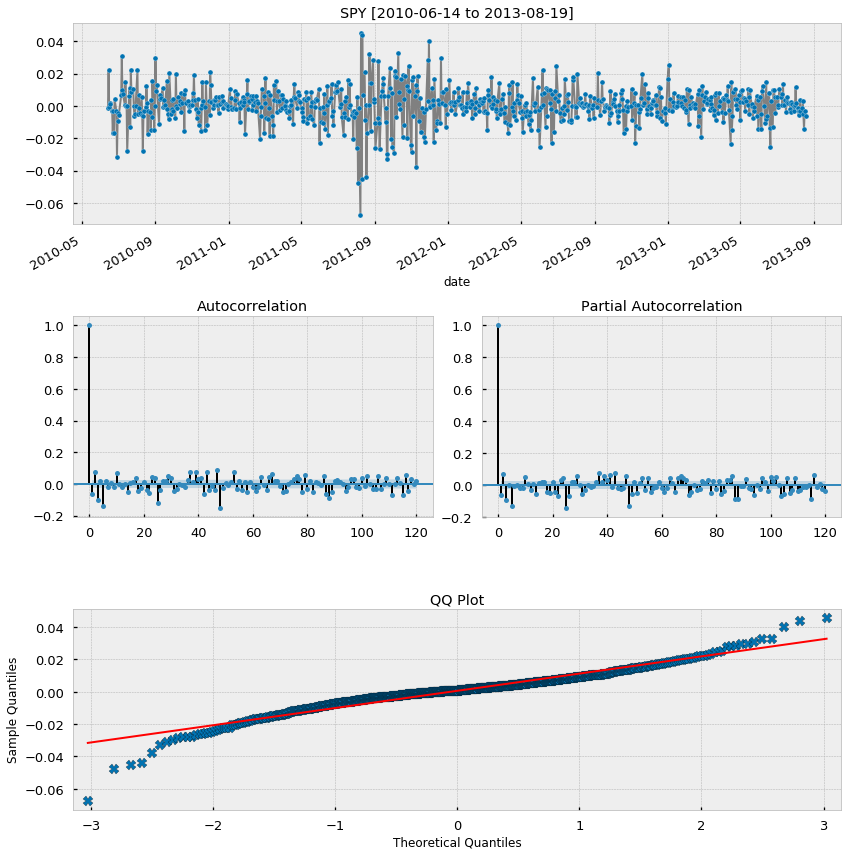

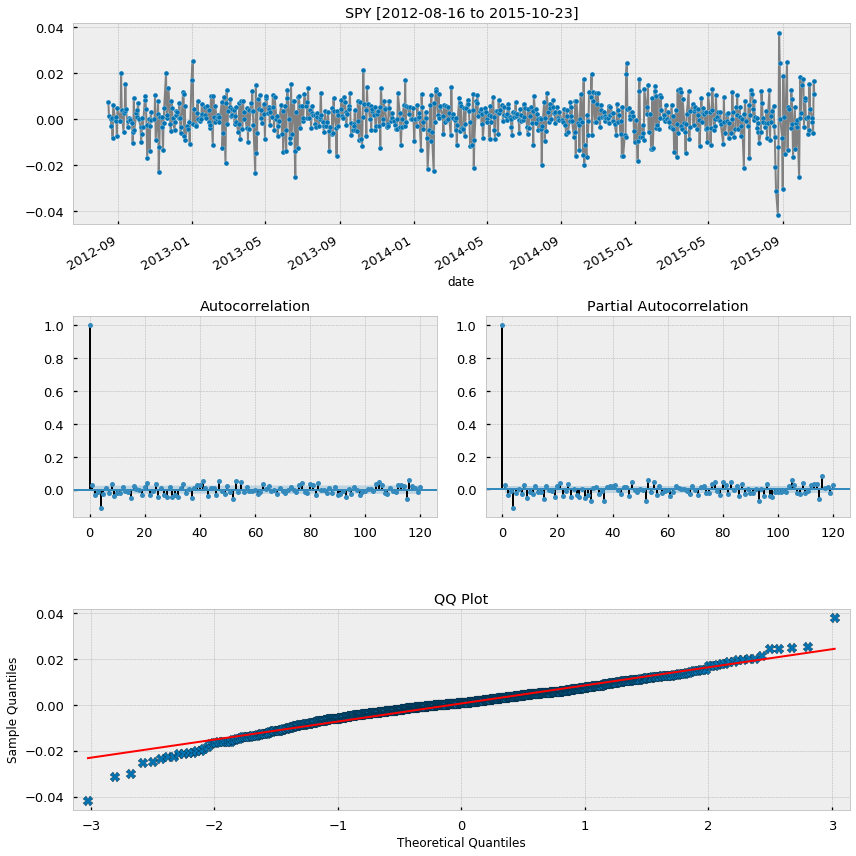

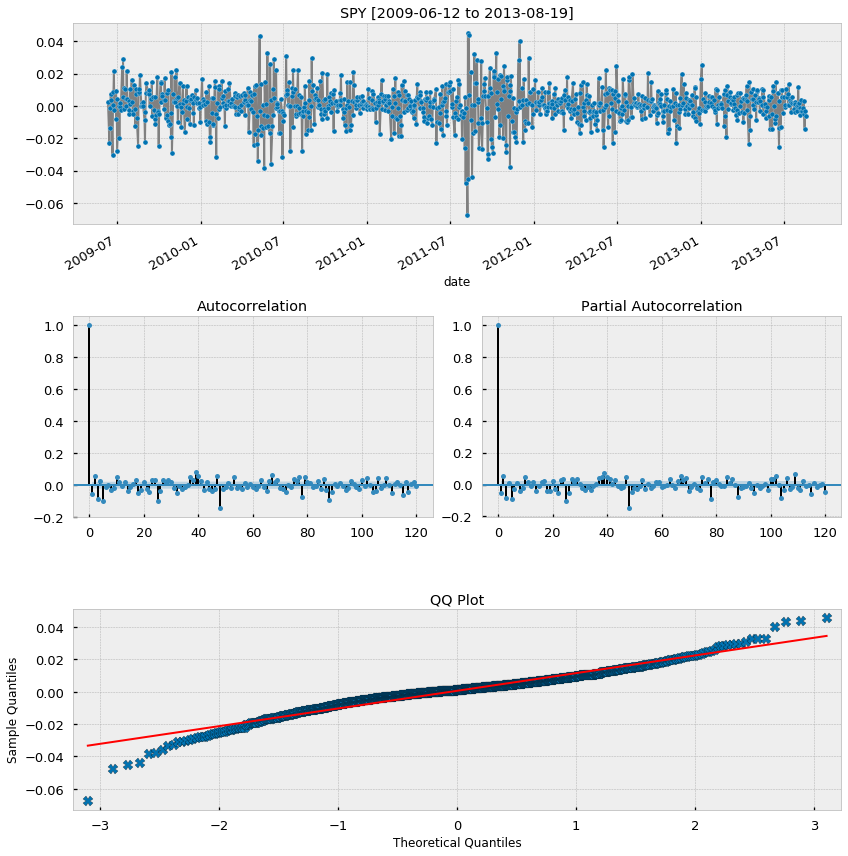

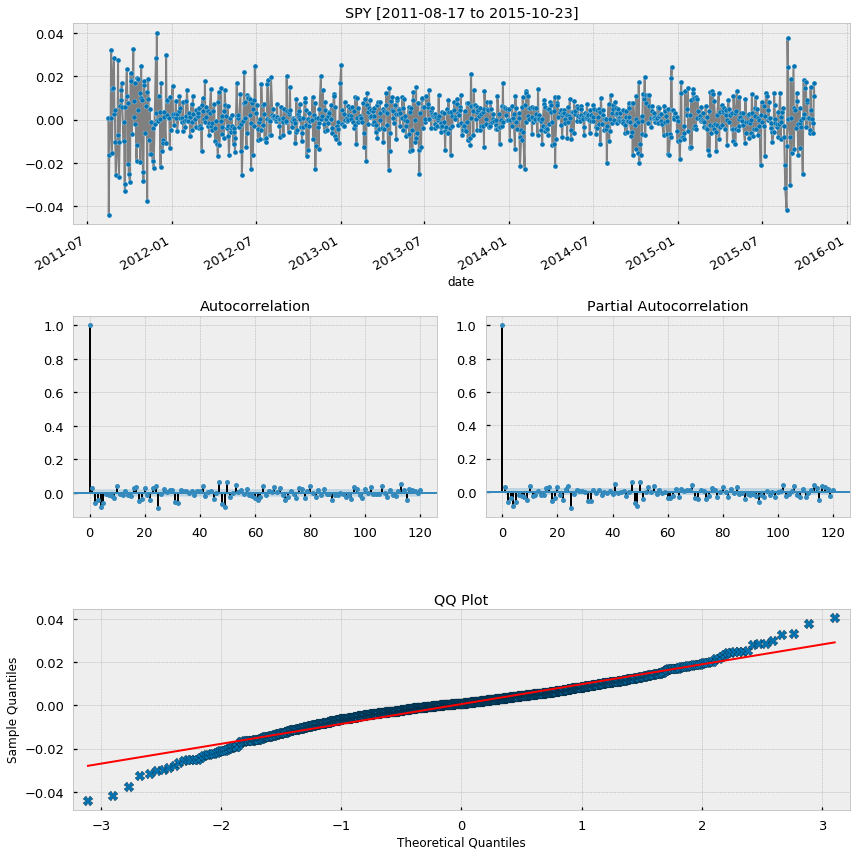

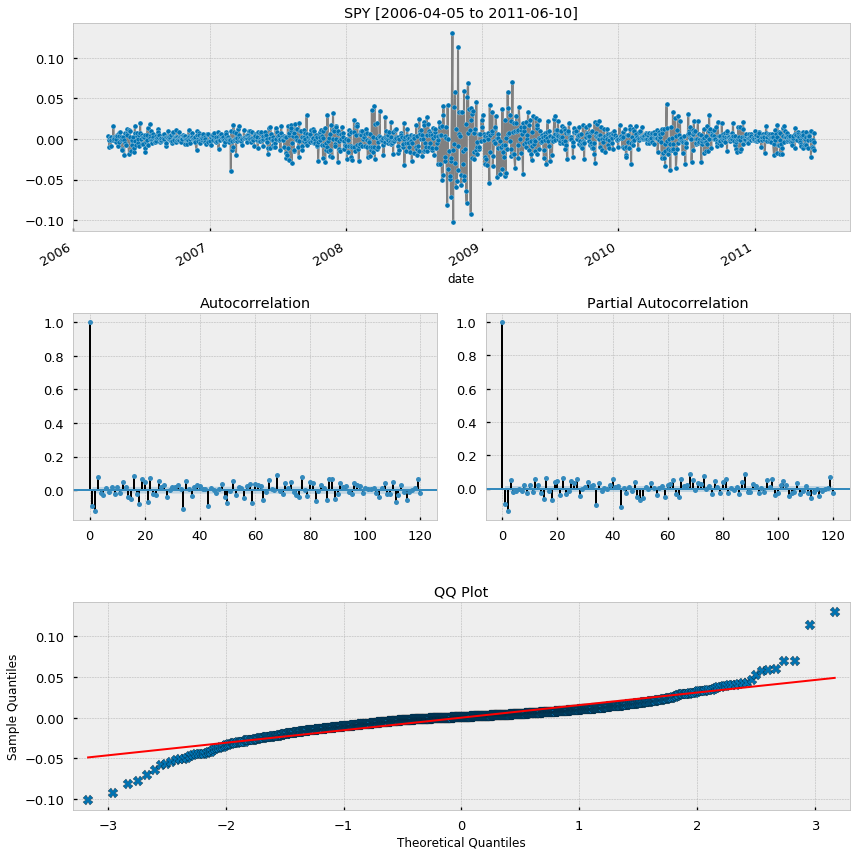

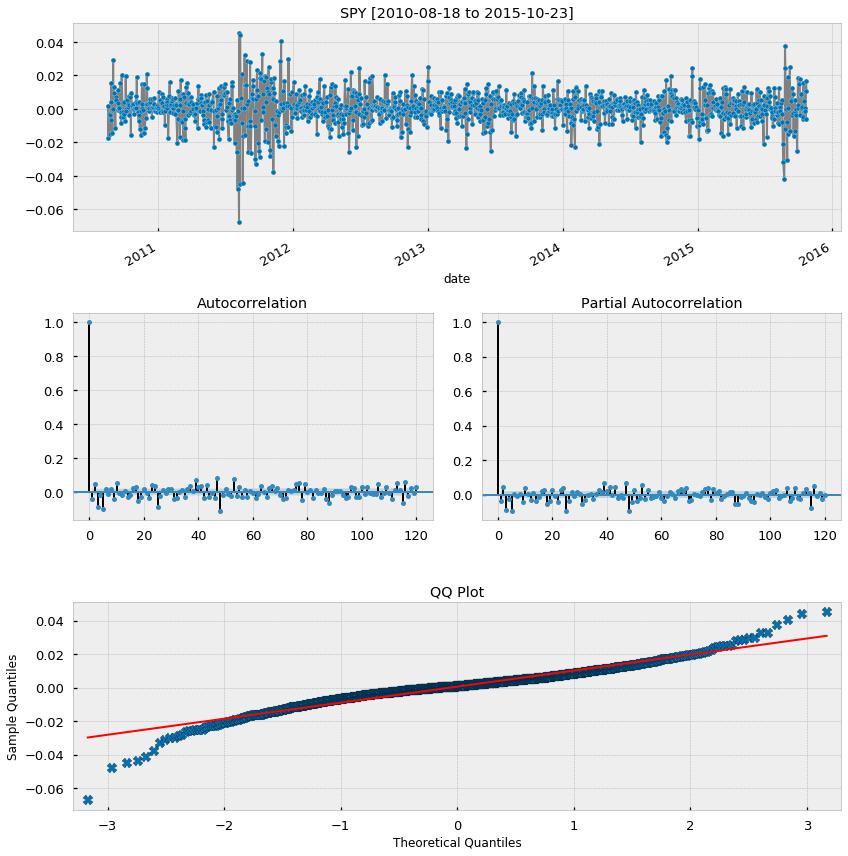

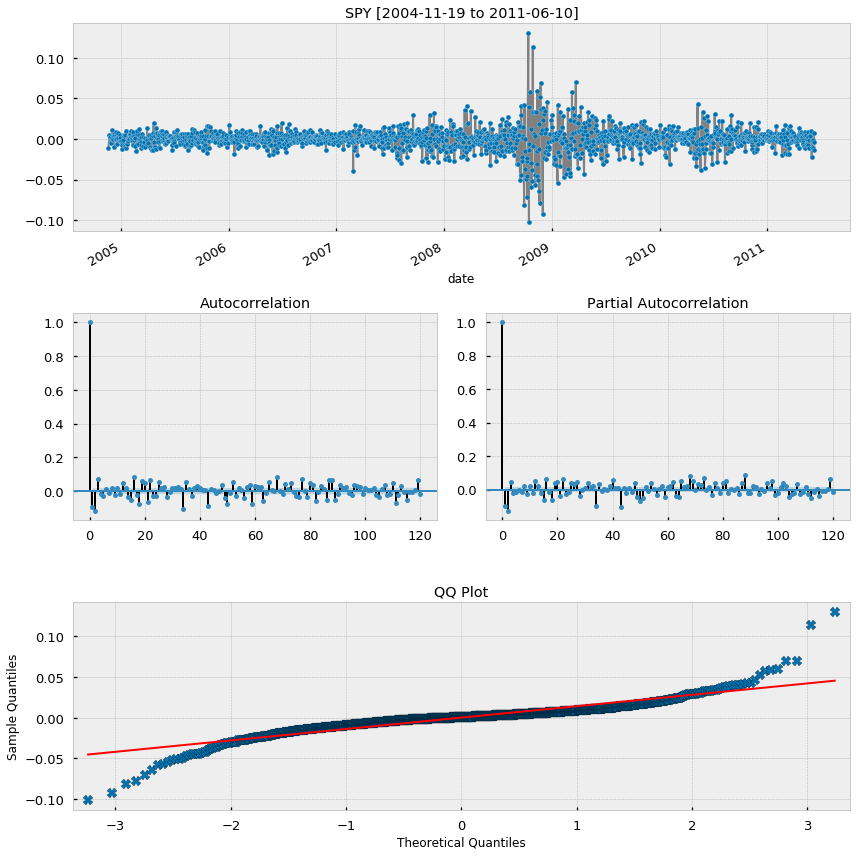

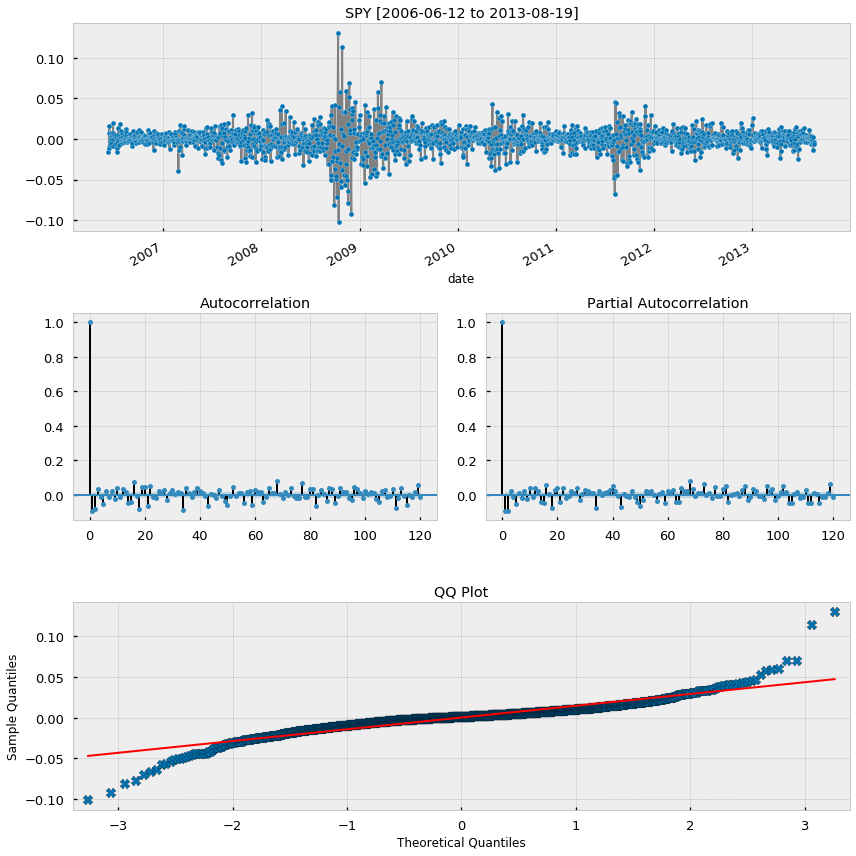

In [23]:
for row in tss_ks_df.query('p>@a1').itertuples():
    tmp_R = R.loc[pd.to_datetime(row.min_train_dt):pd.to_datetime(row.max_test_dt)]
    tmp_s = tmp_R[SYM]
    tmp_s.name = f'{SYM} [{row.min_train_dt} to {row.max_test_dt}]'
    tsplot(tmp_s, lags=120, figsize=(12,12))

At a glance, it looks like the `ks_2samp` test was likely to accept the null hypothesis when the training and test periods contained significant periods of lower, stable volatility, *or* when the high volatility periods were split among both training and testing periods.

## Conclusions

Regarding asset returns we've seen that the means and variances are not stationary, and that there is autocorrelation between returns at differing lags, and multiple time scales. We've also seen how there is potential for large errors/losses if we assume that the return distribution from the previous period(s) to the next are the same because in most cases they are not.

Hopefully this notebook shows that there is a need for a modeling framework that can overcome these challenges in a robust manner. In the next chapter I hope to demonstrate how mixture models approach these issues and the potential benefits they bring to this task.

## Resources and Citations

1. https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
2. https://pydata.github.io/pandas-datareader/stable/remote_data.html#tiingo
3. http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016